In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler as minmax
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

In [2]:
tf.__version__

'2.0.0-alpha0'

In [3]:
data = pd.read_csv("data/nyc.csv",parse_dates=['Date'],index_col='Date')
data.head()

,Unnamed: 0,Max.TemperatureF,Mean.TemperatureF,Min.TemperatureF,Max.Dew.PointF,MeanDew.PointF,Min.DewpointF,Max.Humidity,Mean.Humidity,Min.Humidity,...,Min.VisibilityMiles,Max.Wind.SpeedMPH,Mean.Wind.SpeedMPH,Max.Gust.SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees.br...,city,season
Date,,,,,,,,,,,,,,,,,,,,,
1948-07-01,1,84,78.0,72,71,65,58,93,65,46,...,2.0,16,8,NaN,0.00,0.0,Fog,264<br />,New York City (USA),Summer
1948-07-02,2,82,72.0,63,62,53,49,76,51,33,...,10.0,16,10,NaN,0.00,0.0,NaN,315<br />,New York City (USA),Summer
1948-07-03,3,78,71.0,64,66,58,53,84,62,42,...,5.0,14,6,NaN,0.00,0.0,NaN,203<br />,New York City (USA),Summer
1948-07-04,4,84,76.0,68,68,63,56,90,67,38,...,2.0,12,5,NaN,0.00,0.0,Fog,198<br />,New York City (USA),Summer
1948-07-05,5,93,82.0,70,74,69,65,93,71,40,...,3.0,18,8,NaN,0.00,0.0,Fog-Rain-Thunderstorm,218<br />,New York City (USA),Summer


In [4]:
train_cols = ["Mean.TemperatureF","Mean.Humidity","Mean.Wind.SpeedMPH"]
data = data[train_cols]

In [5]:
data.isna().sum()

Mean.TemperatureF     2
Mean.Humidity         0
Mean.Wind.SpeedMPH    0
dtype: int64

In [6]:
data.dropna(inplace=True)

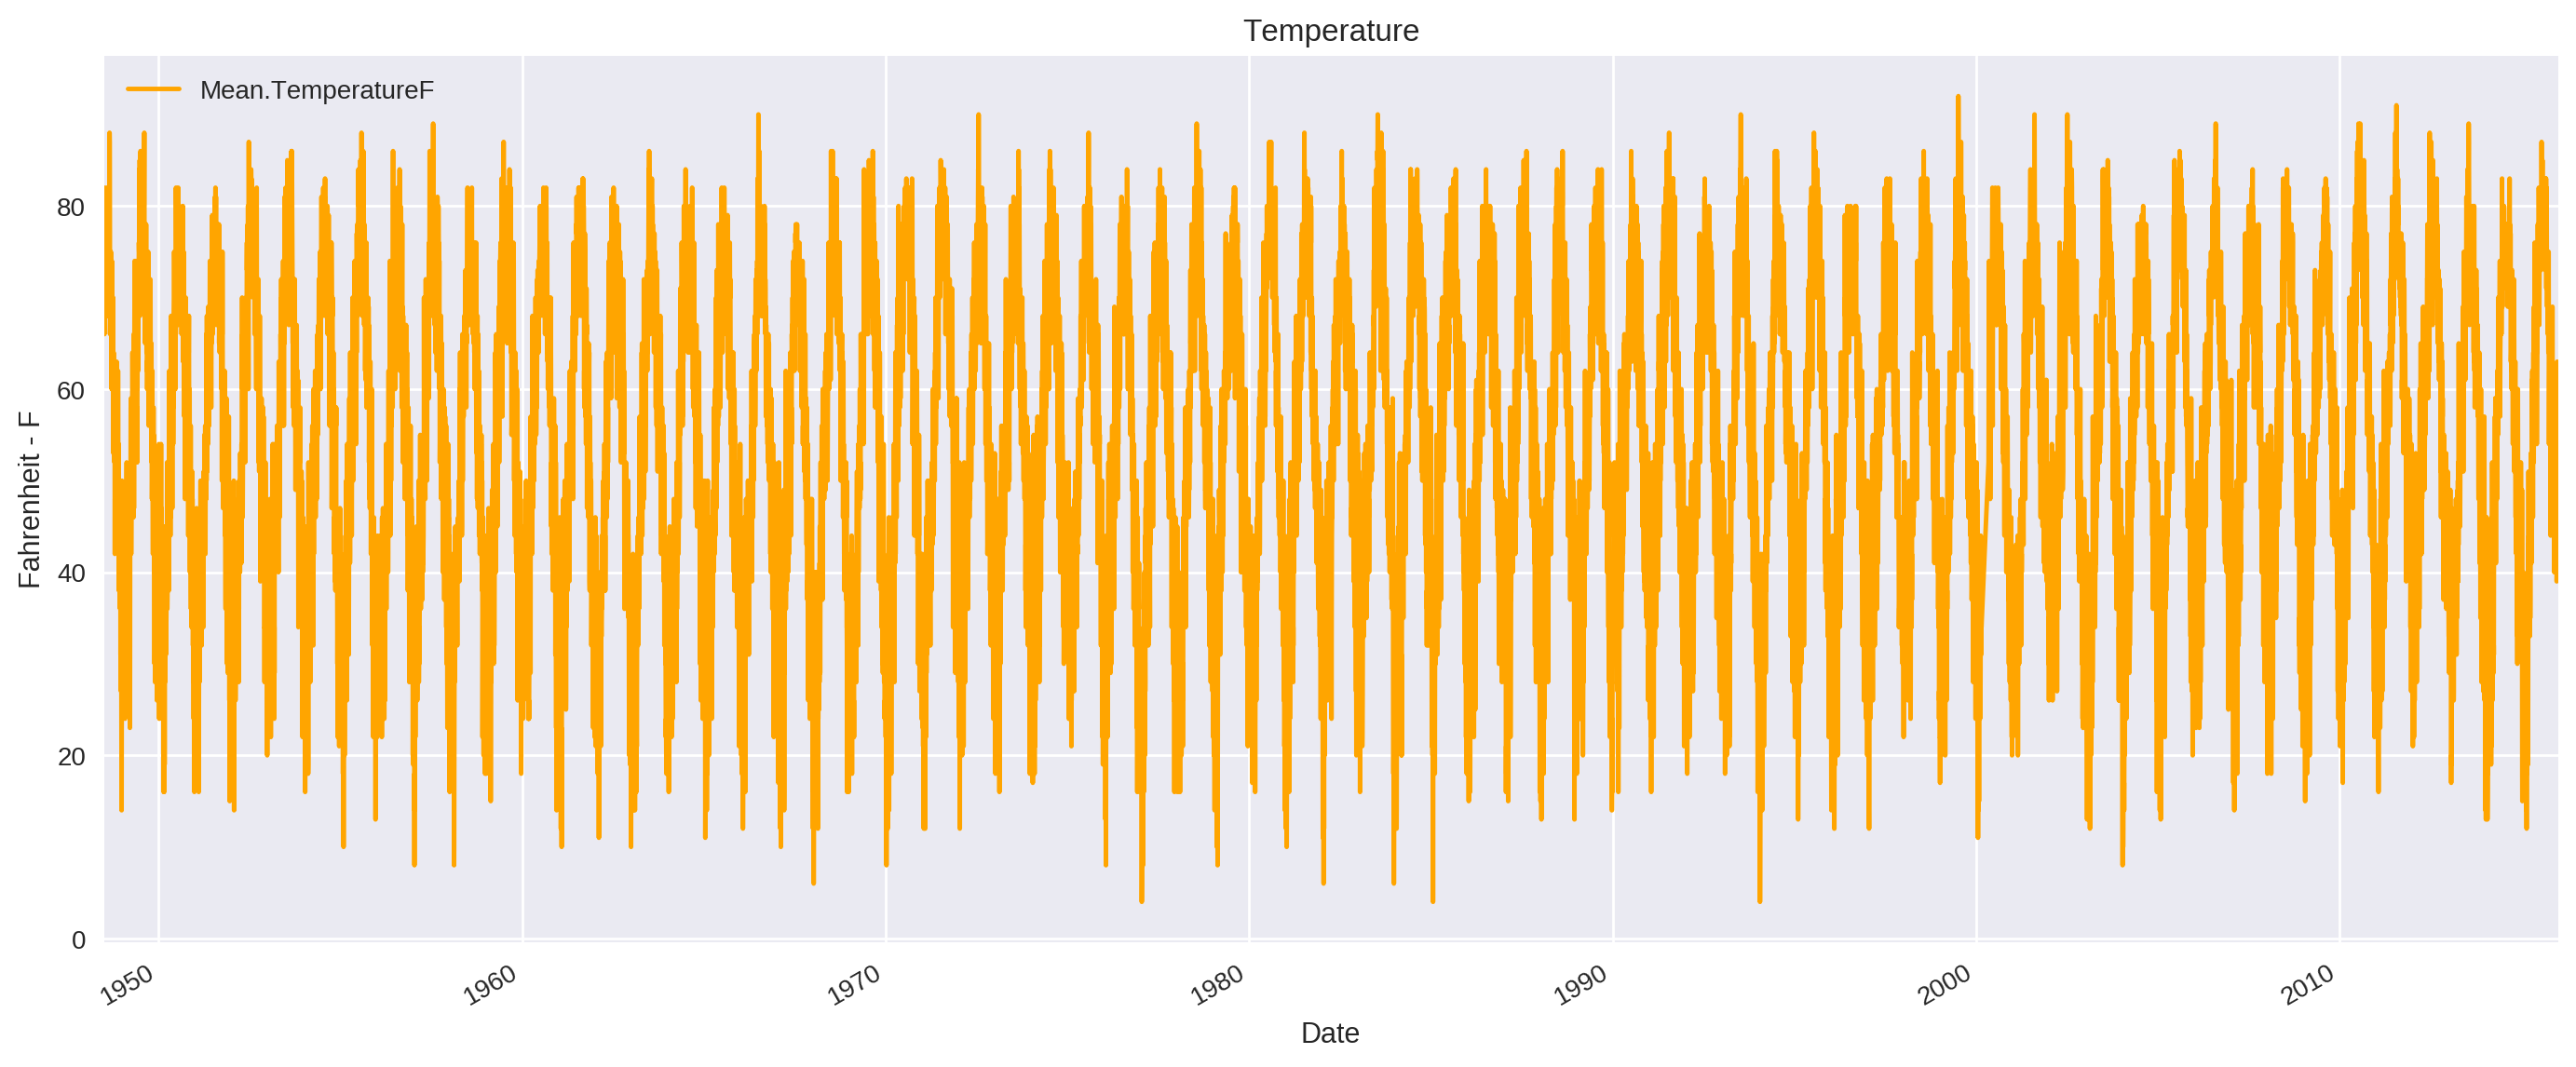

In [7]:
#Visualize our data

plt.figure(dpi=200,figsize=(17,7))
data["Mean.TemperatureF"].plot(legend=True,color='orange')
plt.title('Temperature')
plt.ylabel("Fahrenheit - F")
plt.show()

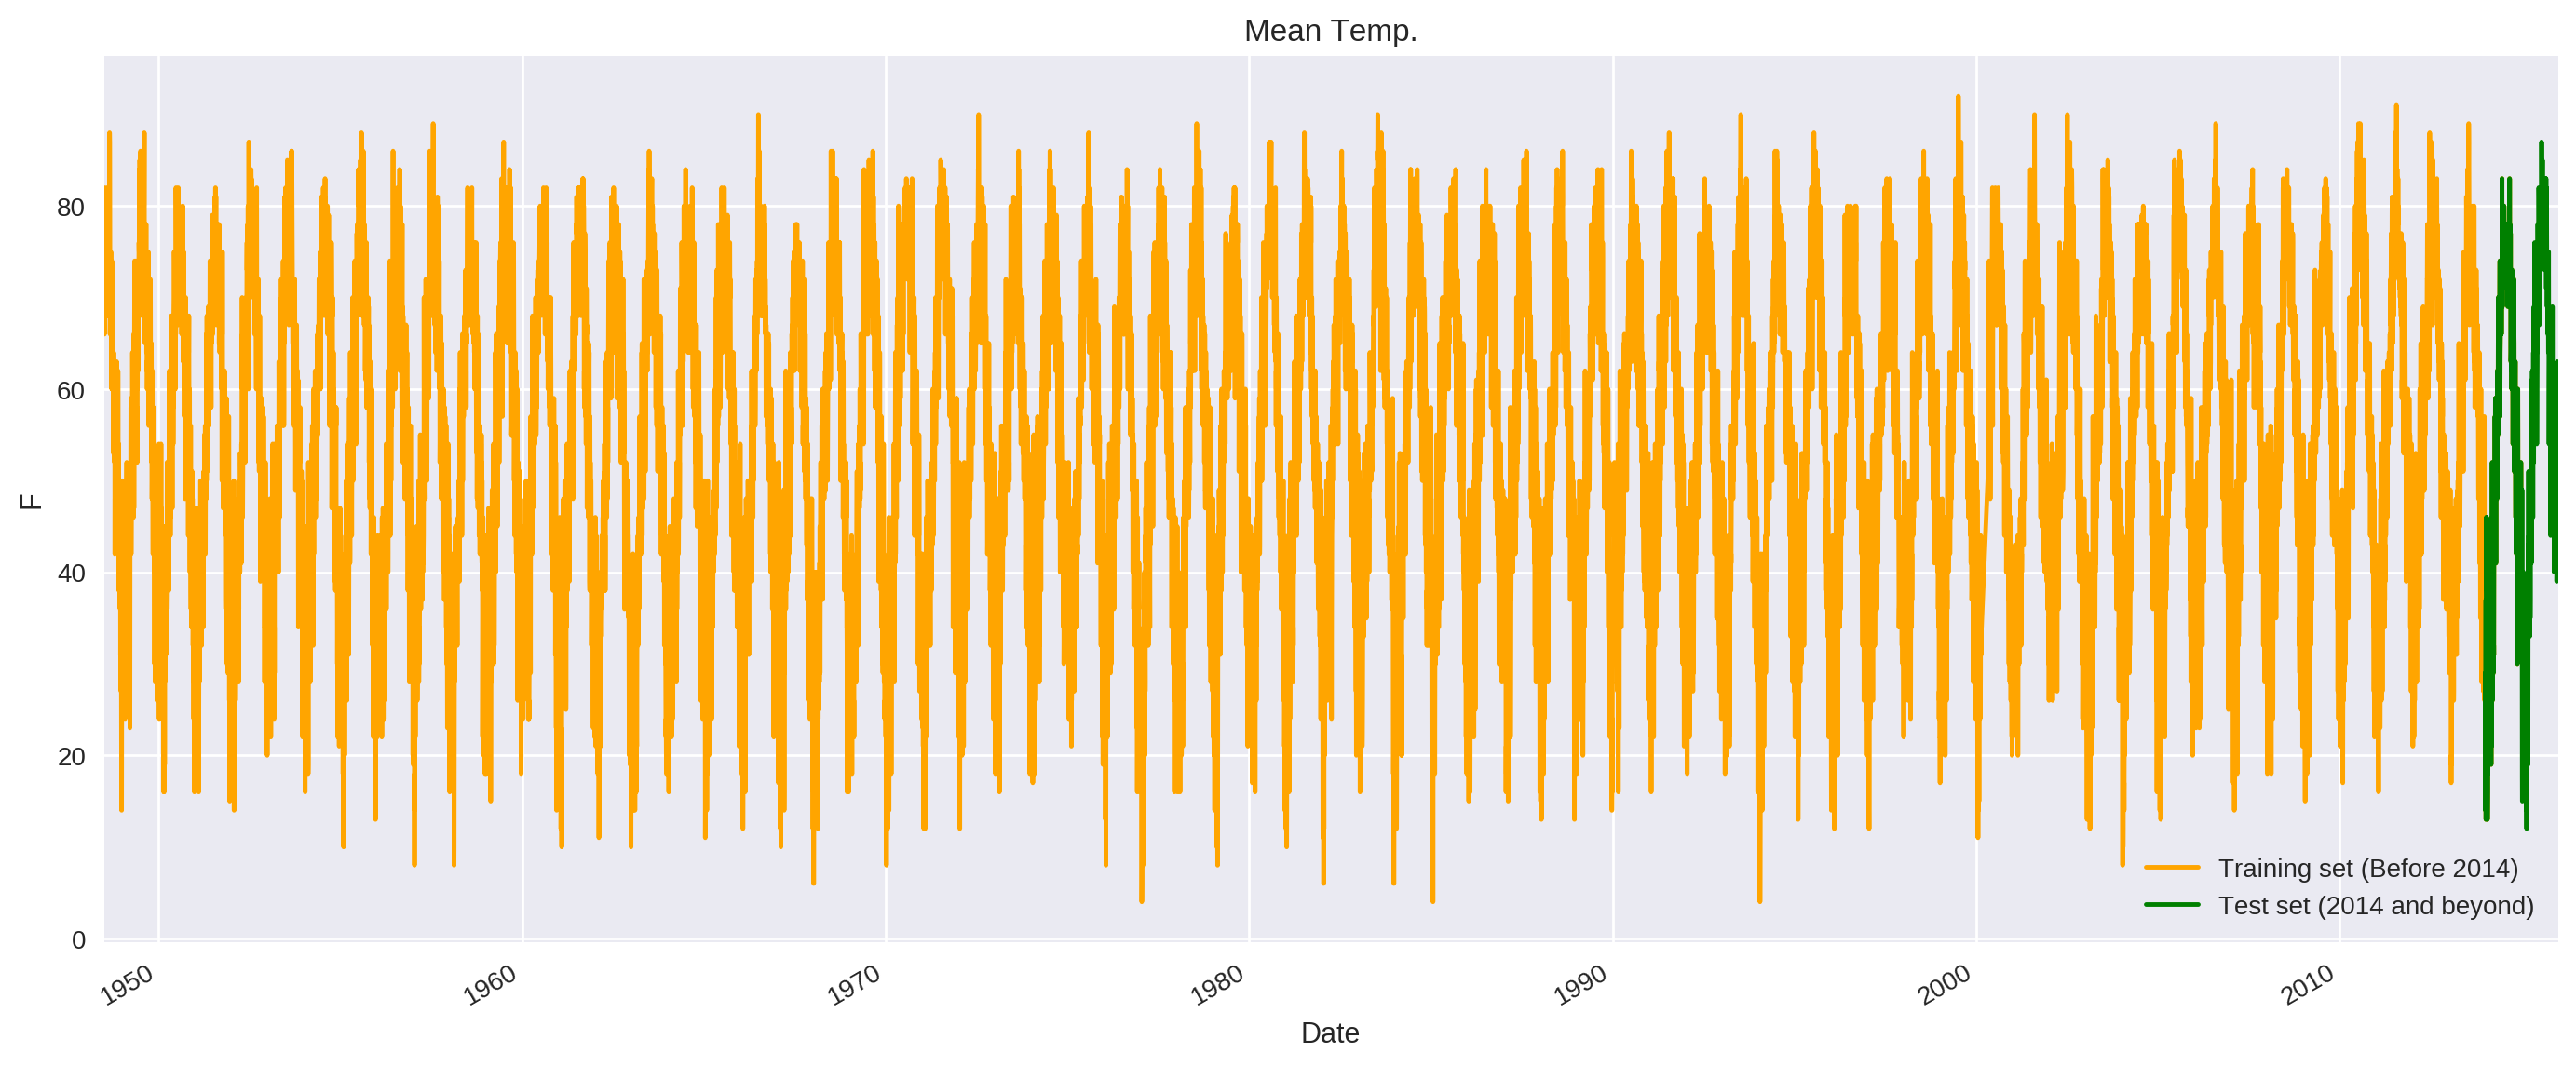

In [8]:
#Visualize our data - 2

plt.figure(dpi=200,figsize=(17,7))
data["Mean.TemperatureF"][:'2014'].plot(legend=True,color='orange')
data["Mean.TemperatureF"]['2014':].plot(legend=True,color='green')
plt.legend(['Training set (Before 2014)','Test set (2014 and beyond)'])
plt.title('Mean Temp.')
plt.ylabel("F")
plt.show()

In [9]:
def make_dataset_many_to_many(array,time_steps):

    x = []
    y = []

    for i in range(time_steps,len(array)):
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

In [10]:
train = data[:"2014"].values

#scale values between 0 and 1
scaler = minmax(feature_range=(0,1))

train = scaler.fit_transform(train)

trn_x,trn_y = make_dataset_many_to_many(train,60)

## The three dimensions of this input are:

* **Samples**. One sequence is one sample. A batch is comprised of one or more samples.
* **Time Steps**. One time step is one point of observation in the sample.
* **Features**. One feature is one observation at a time step.

In [11]:
trn_x = trn_x.reshape(-1,60,3)

print(trn_x.shape,trn_y.shape)

(24133, 60, 3) (24133, 3)


### Model Architecture

* LSTM(50)
* LSTM(50)
* Dense(500)
* Dropout(0.2)
* Dense(1)

In [12]:
model = tf.keras.models.Sequential()

model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, return_sequences=True))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, return_sequences=True))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50))

model.add(tf.keras.layers.Dense(500))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(3))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=15)
model.compile(optimizer='adam', loss='mse', callbacks=[early_stop])

In [13]:
model.fit(trn_x, trn_y, epochs=30)

Epoch 1/30
24133/24133 [==============================] - 9s 359us/sample - loss: 0.0187
Epoch 2/30
24133/24133 [==============================] - 7s 292us/sample - loss: 0.0141
Epoch 3/30
24133/24133 [==============================] - 7s 302us/sample - loss: 0.0132
Epoch 4/30
24133/24133 [==============================] - 7s 280us/sample - loss: 0.0128
Epoch 5/30
24133/24133 [==============================] - 7s 306us/sample - loss: 0.0127
Epoch 6/30
24133/24133 [==============================] - 7s 304us/sample - loss: 0.0125
Epoch 7/30
24133/24133 [==============================] - 7s 295us/sample - loss: 0.0122
Epoch 8/30
24133/24133 [==============================] - 7s 305us/sample - loss: 0.0121
Epoch 9/30
24133/24133 [==============================] - 7s 308us/sample - loss: 0.0121
Epoch 10/30
24133/24133 [==============================] - 7s 286us/sample - loss: 0.0121
Epoch 11/30
24133/24133 [==============================] - 8s 311us/sample - loss: 0.0121
Epoch 12/30
24133/2

## Validation

* Test our model on whole data including test set(2014 and beyond)

In [14]:
total = scaler.transform(data.values)
total_x,total_y = make_dataset_many_to_many(total,60)

In [15]:
predicted = model.predict(total_x)

In [16]:
predicted = scaler.inverse_transform(predicted)

In [17]:
#make a dataset with real and predicted values.

infered = pd.DataFrame(data.iloc[60:])
infered['Mean.TemperatureF_Predicted'] = predicted[:,0]
infered['Mean.Humidity_Predicted'] = predicted[:,1]
infered['Mean.Wind.SpeedMPH_Predicted'] = predicted[:,2]

In [18]:
infered.tail()

,Mean.TemperatureF,Mean.Humidity,Mean.Wind.SpeedMPH,Mean.TemperatureF_Predicted,Mean.Humidity_Predicted,Mean.Wind.SpeedMPH_Predicted
Date,,,,,,
2015-12-27,56.0,82,12,51.685703,64.198647,11.760435
2015-12-28,42.0,57,14,56.126991,73.892708,13.681645
2015-12-29,42.0,88,12,39.985195,59.780121,12.232966
2015-12-30,46.0,85,7,46.180939,74.965775,14.634055
2015-12-31,48.0,71,12,48.288681,75.451904,11.240332


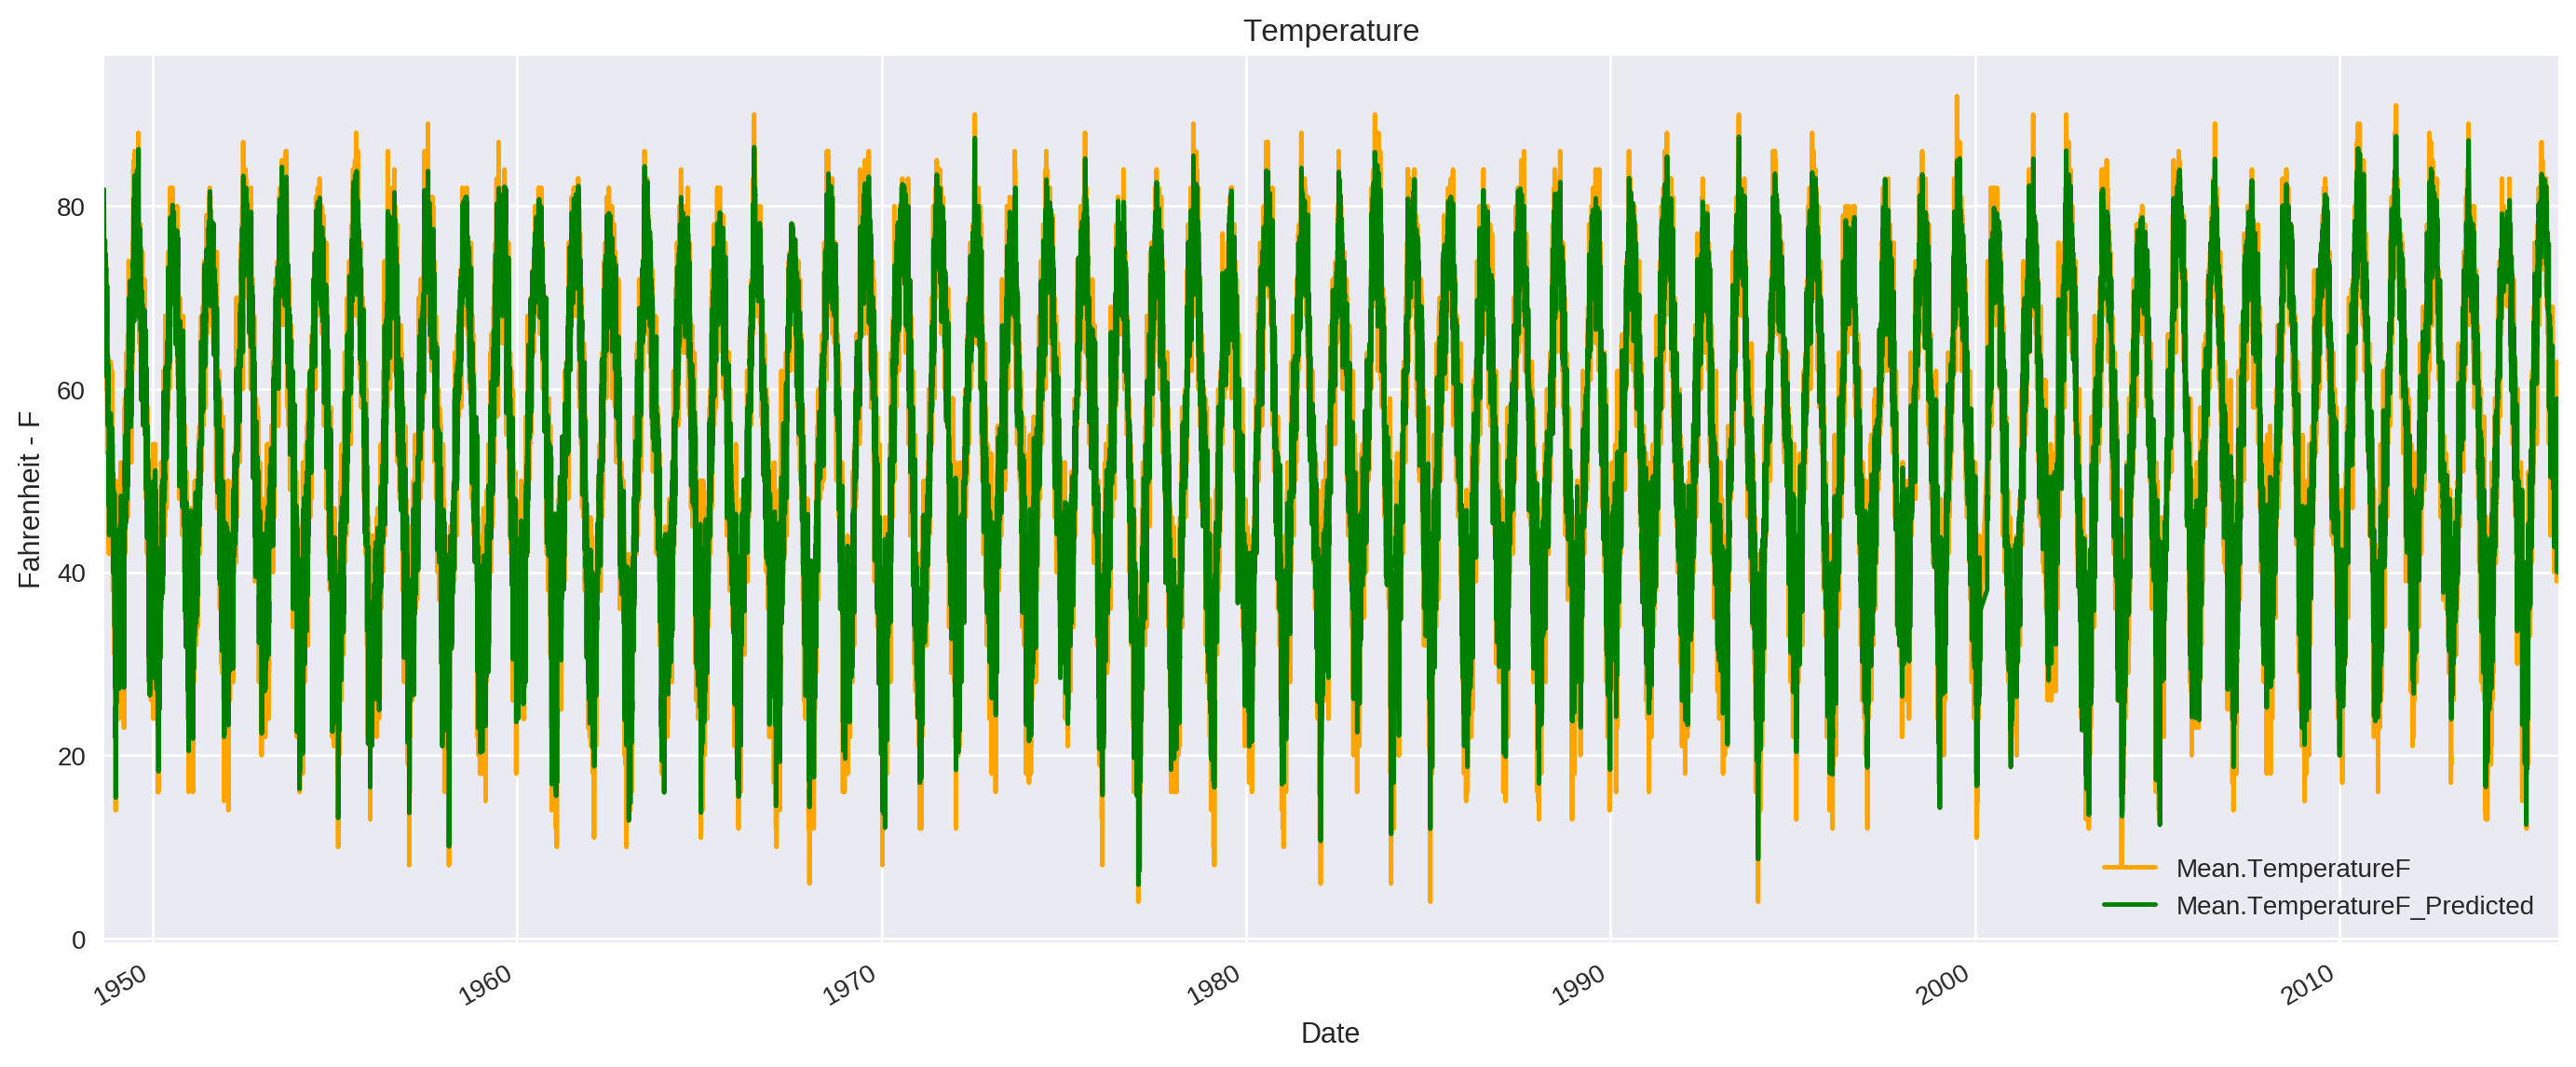

In [19]:
plt.figure(dpi=200,figsize=(17,7))
infered["Mean.TemperatureF"].plot(legend=True,color='orange')
infered["Mean.TemperatureF_Predicted"].plot(legend=True,color='green')
plt.title('Temperature')
plt.ylabel("Fahrenheit - F")
plt.show()

## Testset visualization

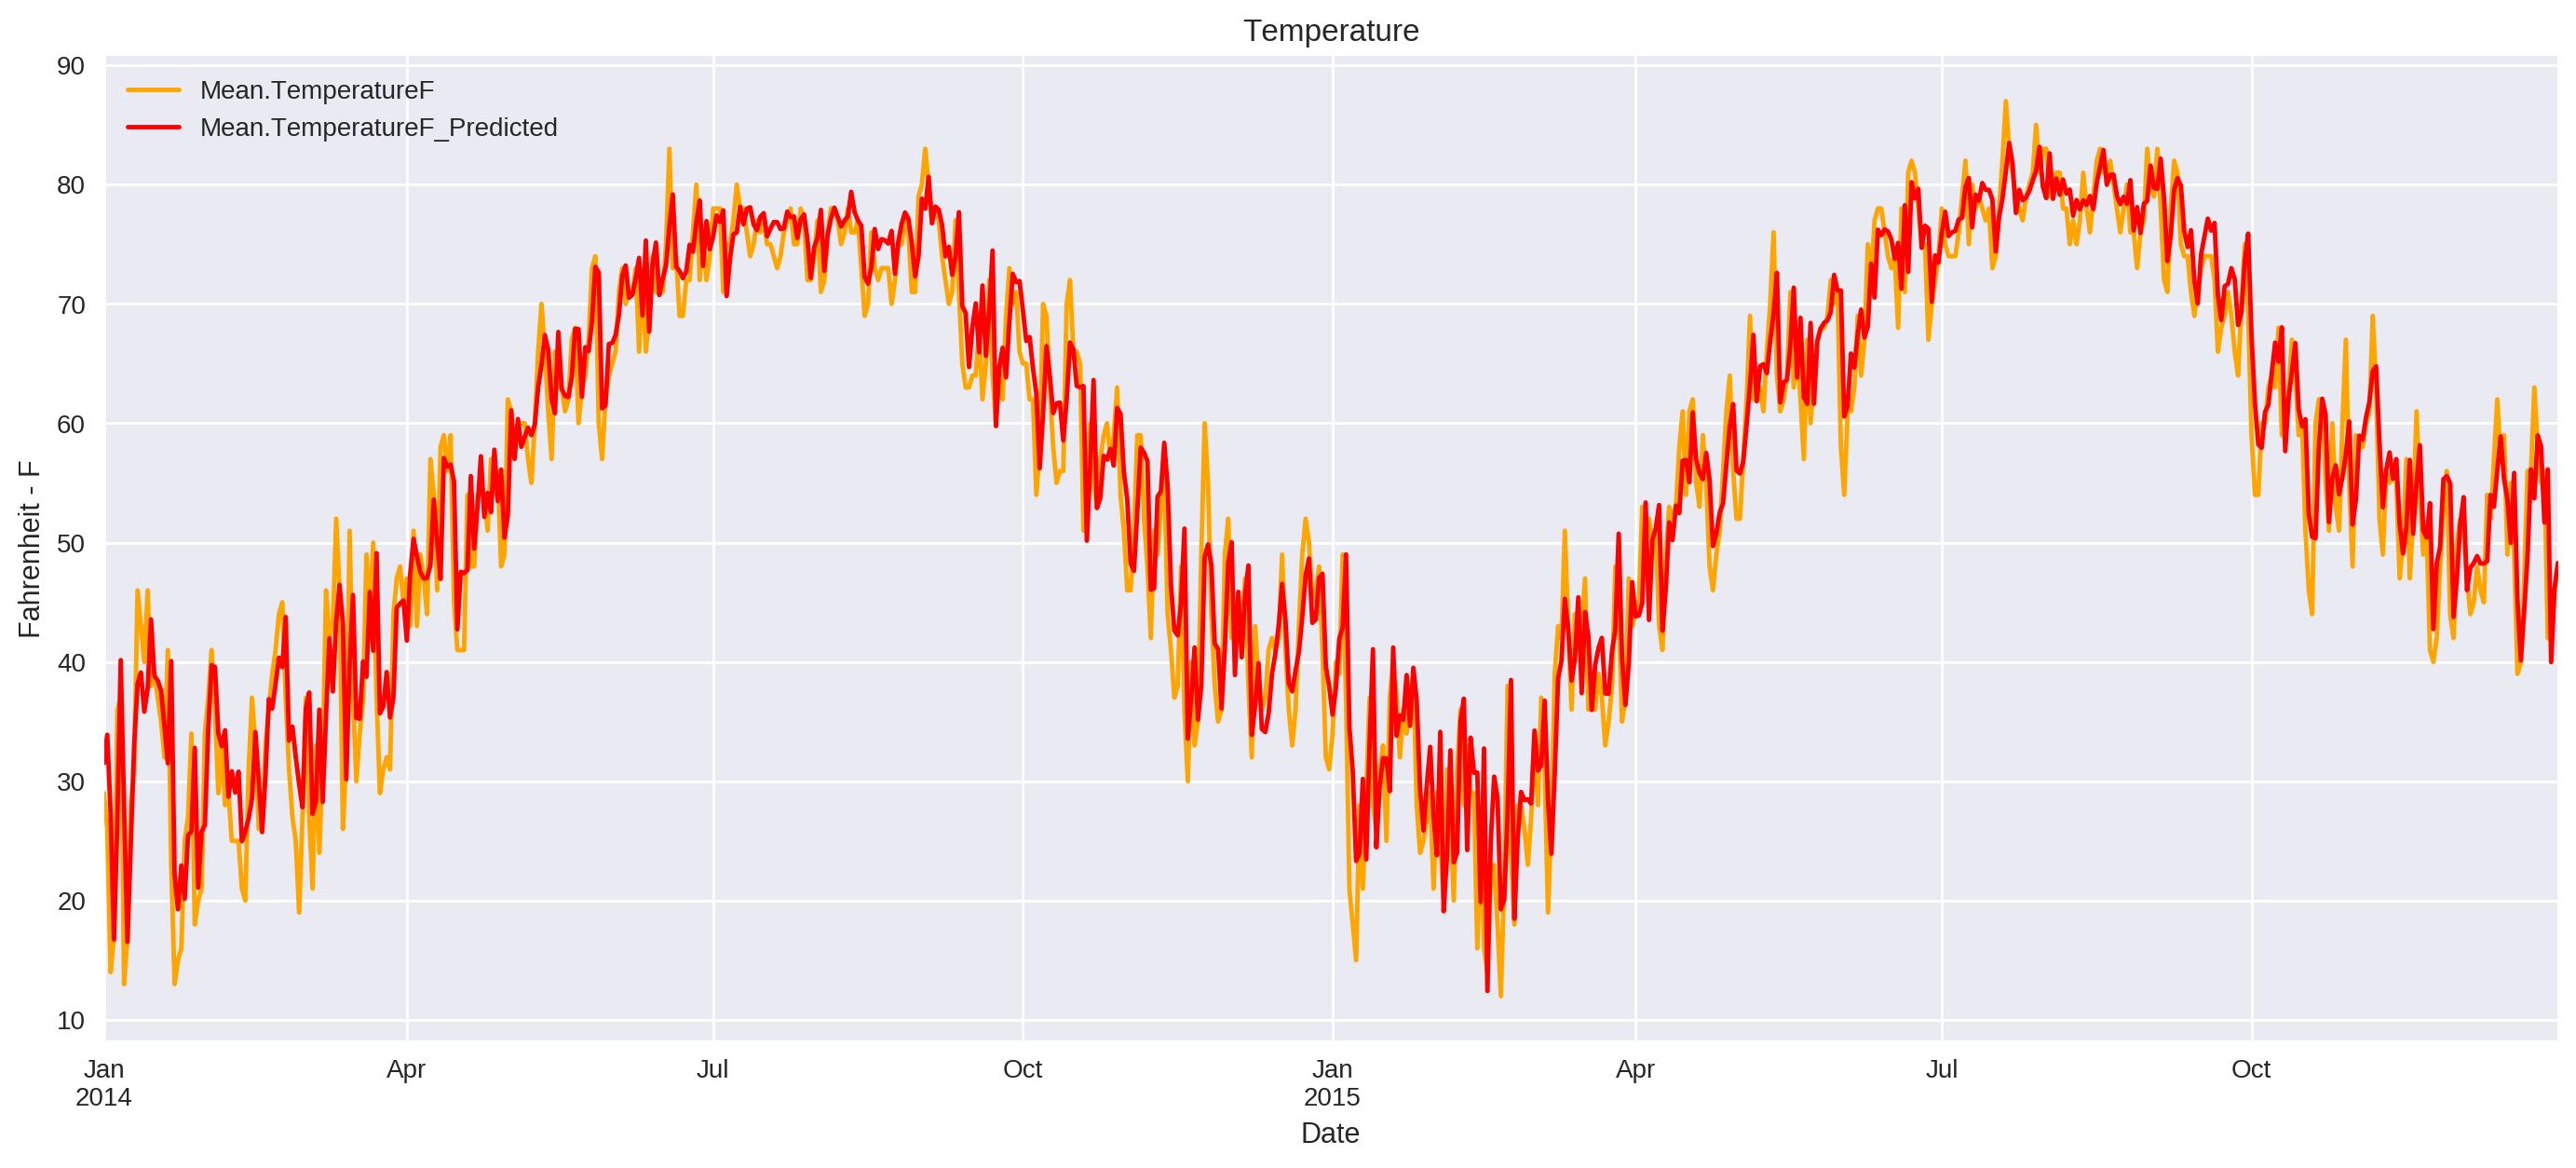

In [20]:
plt.figure(dpi=200,figsize=(17,7))
infered["2014":]["Mean.TemperatureF"].plot(legend=True,color='orange')
infered["2014":]["Mean.TemperatureF_Predicted"].plot(legend=True,color='red')
plt.title('Temperature')
plt.ylabel("Fahrenheit - F")
plt.show()

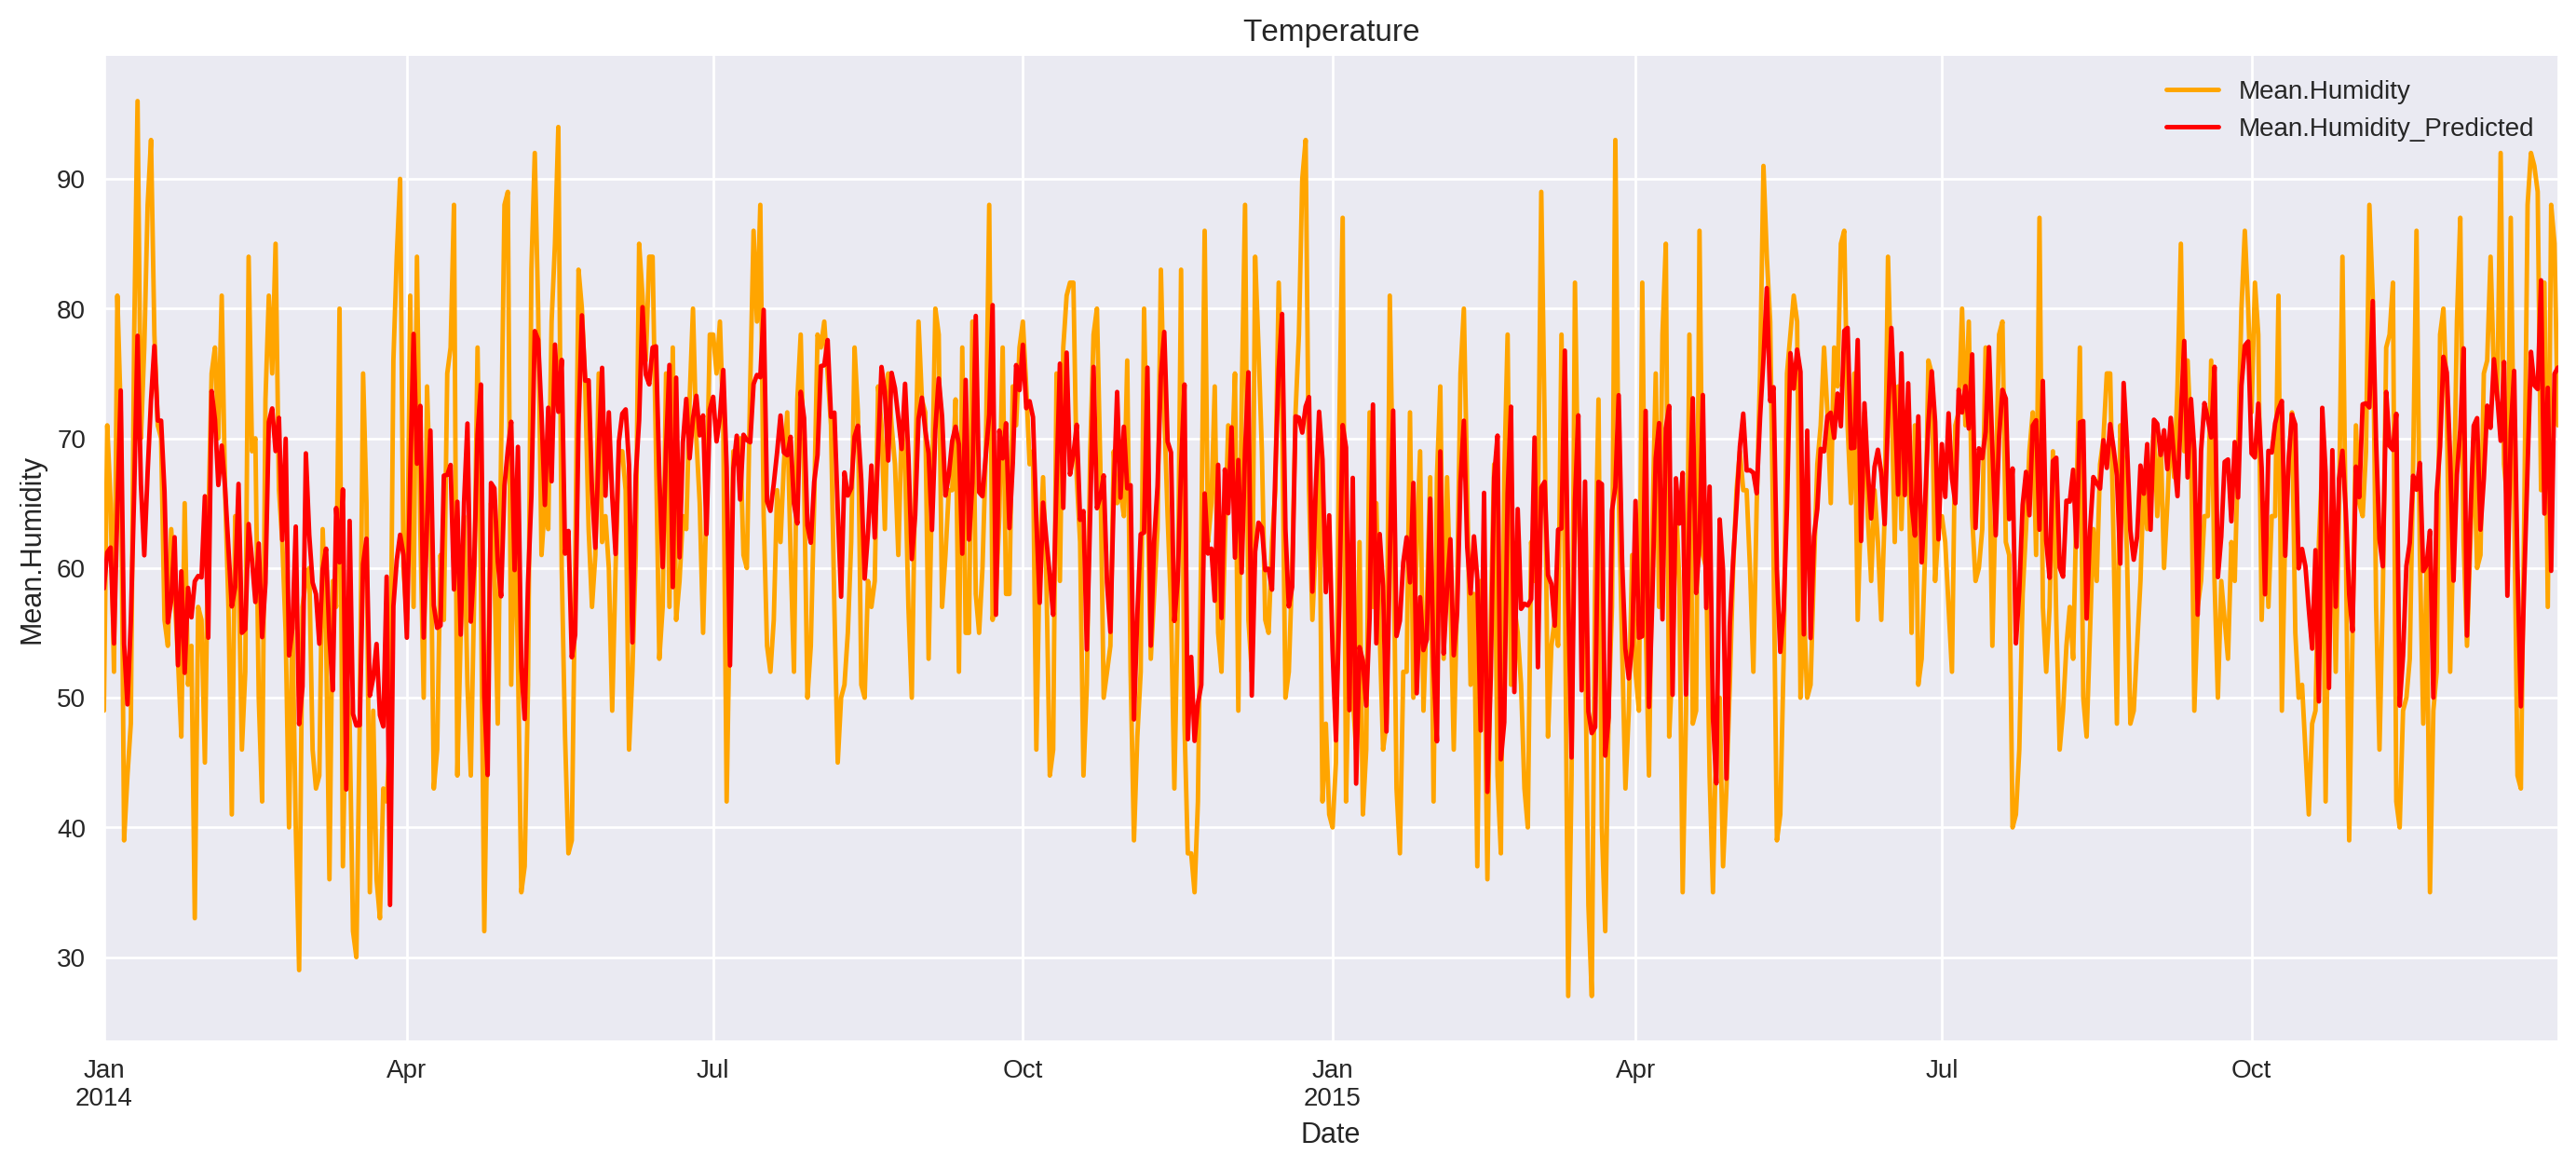

In [21]:
plt.figure(dpi=200,figsize=(17,7))
infered["2014":]["Mean.Humidity"].plot(legend=True,color='orange')
infered["2014":]["Mean.Humidity_Predicted"].plot(legend=True,color='red')
plt.title('Temperature')
plt.ylabel("Mean.Humidity")
plt.show()

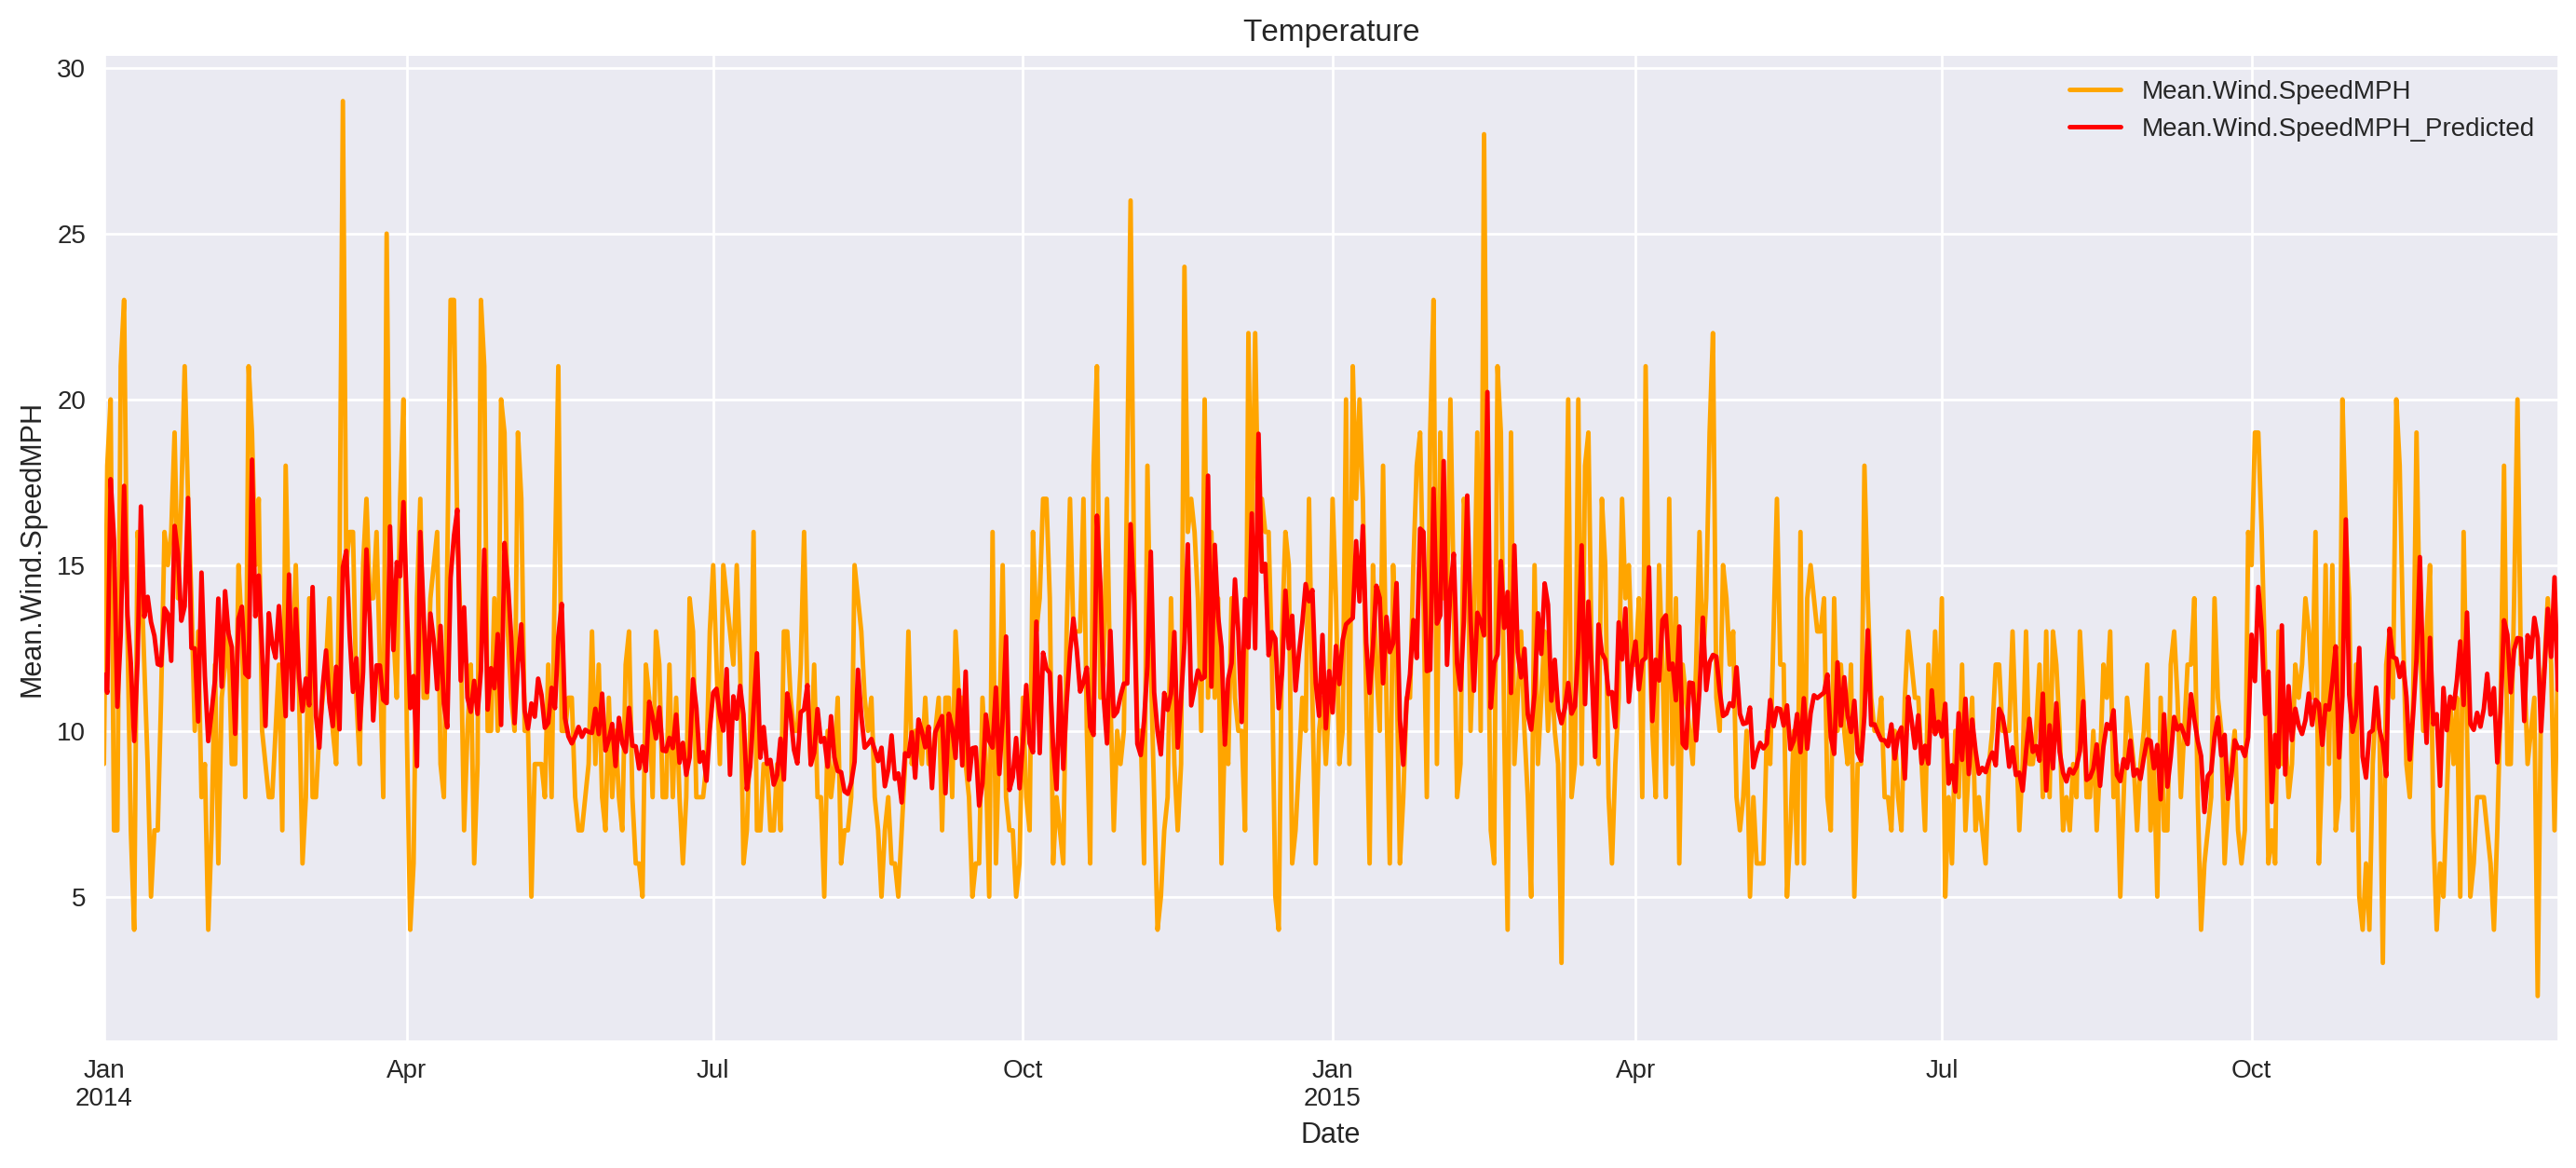

In [22]:
plt.figure(dpi=200,figsize=(17,7))
infered["2014":]["Mean.Wind.SpeedMPH"].plot(legend=True,color='orange')
infered["2014":]["Mean.Wind.SpeedMPH_Predicted"].plot(legend=True,color='red')
plt.title('Temperature')
plt.ylabel("Mean.Wind.SpeedMPH")
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(infered[["Mean.TemperatureF","Mean.Humidity","Mean.Wind.SpeedMPH"]],infered[["Mean.TemperatureF_Predicted","Mean.Humidity_Predicted","Mean.Wind.SpeedMPH_Predicted"]])
print("RMSE:", np.sqrt(mse))

RMSE: 7.906251184110699


In [24]:
#save model

model.save("models/tf.keras/model")